In [104]:
from ansys.mapdl.core import launch_mapdl
import numpy as np
import matplotlib.pyplot as plt

def plot_Deformation(x_N,y_N,ux,uy):
    # --- Settings ---
    scale = 1  # deformation magnification
    mode_color = 'b'
    mode_label = 'Deformed'
    node_marker_size = 6
    node_fill_color = 'yellow'

    # --- Undeformed coordinates ---
    x_orig = x_N
    y_orig = y_N

    # --- Deformed coordinates ---
    x_def = x_orig + scale * ux
    y_def = y_orig + scale * uy

    # --- Plot ---
    plt.figure(figsize=(10, 4))

    # Plot undeformed shape
    plt.plot(x_orig, y_orig, 'k--', label="Undeformed", linewidth=1)

    # Plot deformed shape
    plt.plot(x_def, y_def, color=mode_color, label=mode_label, linewidth=2)
    plt.plot(
        x_def, y_def,
        'o',
        markerfacecolor=node_fill_color,
        markeredgecolor=mode_color,
        markersize=node_marker_size
    )

    # --- Final layout ---
    plt.axis("equal")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Undeformed vs Deformed Shape")
    plt.legend()
    plt.tight_layout()
    plt.grid()
    plt.show()

### Properties of arch

Shallow arch under vertical point load

![alt text](image.png)

In [105]:
R = 40              # radius in m
alpha = 20          # half of open angle in °
n_El = 30           # number of elements
Fref = -100E3       # magnitude of vertical force at top in N

Ex = 2.1E11         # Youngs modulus
nu = 0.3            # Poisson ratio

b = 0.05            # width in m
h = 0.20            # heigth in m 

### Discretization
Generate ANSYS input file

In [106]:
# MAPDL starten
mapdl = launch_mapdl(nproc=1)

# Start mapdl and clear it.
mapdl.clear()
mapdl.verify()

# Enter verification example mode and the pre-processing routine.
mapdl.prep7()

# Type of analysis: static.

# Element type: BEAM188.
mapdl.et(1, "188")
# 2D analysis (uy, ux and rotz)
# ! element y axis coincide with global -Z axis
mapdl.keyopt(1, 5, 1)   

# Material type: linear elastic
mapdl.mp("EX", 1, Ex)           # Youngs modulus N/m^2
mapdl.mp("PRXY", 1, nu)             # Poisson ratio

# cross section of beam
mapdl.sectype(1, "Beam", "RECT", "my_sec")  # rectangular cross section
mapdl.secdata(b, h)                         # b (in element y) and h (in element z) in m

# Define nodes
x_N = R*np.sin(np.linspace(np.deg2rad(-alpha), np.deg2rad(alpha), n_El + 1))
y_N = R*np.cos(np.linspace(np.deg2rad(-alpha), np.deg2rad(alpha), n_El + 1))
for i in range(1, n_El+2):
    mapdl.n(i, x_N[i-1], y_N[i-1], 0)

# Define elements
for i in range(1, n_El+1):  
    mapdl.e(i, i+1)

# BC for the beams seats
mapdl.d(1, "UX")
mapdl.d(1, "UY")
mapdl.d(n_El+1, "UY")
mapdl.d(n_El+1, "UX")

# Load at top
mapdl.f(n_El/2+1, "FY", Fref)

mapdl.finish()

***** ROUTINE COMPLETED *****  CP =         0.000

### Geometric Static Nonlinear Analysis

In [107]:
numSubSteps = 10

mapdl.run("/solu")
mapdl.autots("off")             # automatic time stepping off
mapdl.antype("static")          # static analysis
mapdl.nlgeom("on")              # activate geometric nonlinearities
mapdl.nsubst(numSubSteps)       # number of increments (substeps)
mapdl.outres("basic","all")     # store basic results at any increment

out = mapdl.solve()             # solve
mapdl.finish()

FINISH SOLUTION PROCESSING


 ***** ROUTINE COMPLETED *****  CP =         0.000

### Post processing

*****  INDEX OF DATA SETS ON RESULTS FILE  *****

     SET   TIME/FREQ    LOAD STEP   SUBSTEP  CUMULATIVE
       1 0.10000000             1         1         2                  
       2 0.20000000             1         2         4                  
       3 0.30000000             1         3         6                  
       4 0.40000000             1         4         8                  
       5 0.50000000             1         5        10                  
       6 0.60000000             1         6        12                  
       7 0.70000000             1         7        14                  
       8 0.80000000             1         8        16                  
       9 0.90000000             1         9        18                  
      10  1.0000000             1        10        20


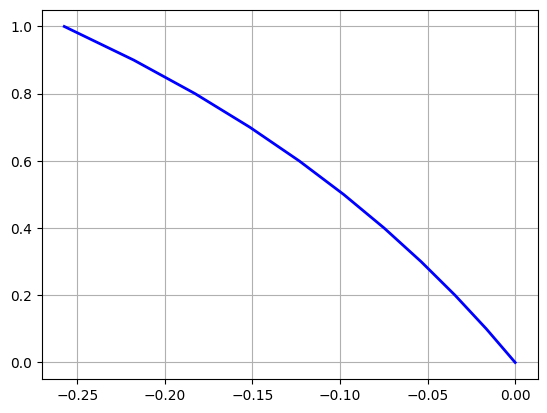

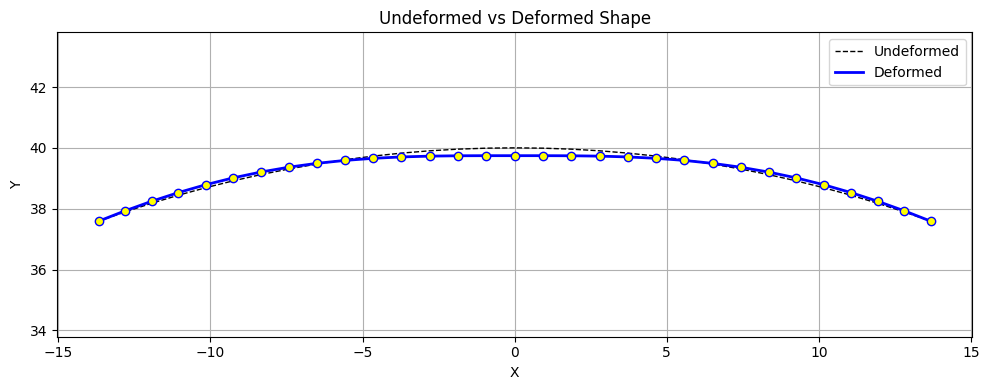

-0.2574315013015075


EXIT THE MAPDL POST1 DATABASE PROCESSOR


 ***** ROUTINE COMPLETED *****  CP =         0.000

In [108]:
# Enter the post-processing routine and select the first load step.
mapdl.post1()

output = mapdl.set("LIST")
print(output)

# monitor DOF
u_monitor_0 = np.zeros((numSubSteps+1,2))
for i in range(1,numSubSteps+1):
    mapdl.set(1, i)
    u_monitor_0[i,1] = mapdl.get_value(entity="NODE", entnum=n_El/2+1, item1="u", it1num="y")
    u_monitor_0[i,0] = mapdl.get_value(entity="ACTIVE", entnum=0, item1="set", it1num="time")

plt.plot(u_monitor_0[:,1], u_monitor_0[:,0], color='blue', linewidth=2)
plt.grid()
plt.show()

# Get nodal displacements
ux = np.zeros(n_El+1)
uy = np.zeros(n_El+1)
for i in range(0, n_El+1):
    ux[i] = mapdl.get_value(entity="NODE", entnum=i+1, item1="u", it1num="x")
    uy[i] = mapdl.get_value(entity="NODE", entnum=i+1, item1="u", it1num="y")

plot_Deformation(x_N, y_N, ux, uy)

print(uy[int(n_El/2)])

mapdl.finish()

### Linear Buckling Analysis

In [109]:
mapdl.run("/solu")
mapdl.antype(status="restart", action="perturb")
mapdl.perturb(type_="buckle", contkey="current", loadcontrol="allkeep")
mapdl.solve("elform")

mapdl.bucopt(method="subsp", nmode="3")
mapdl.outres(item="basic",freq="all")

mapdl.mxpand(nmode="all",elcalc="yes")

out = mapdl.solve()
mapdl.finish()

FINISH SOLUTION PROCESSING


 ***** ROUTINE COMPLETED *****  CP =         0.000

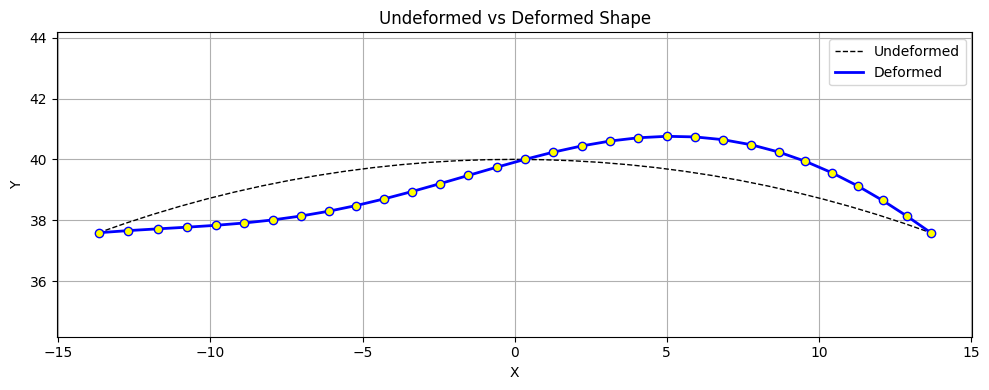

critical load = -152592.95


In [110]:
# read binary mode file for buckling modes and load scaling factor
xpl = mapdl.xpl
xpl.open('file.mode')
#print(xpl.list())
buckModes = xpl.read("SHP","True")
#print(buckModes)
scal_load = xpl.read("FRQ","True")
#print(scal_load)

# Get nodal displacements
ux = np.zeros(n_El+1)
uy = np.zeros(n_El+1)

numMode = 0
scal = 500
ux = scal*buckModes[0::3,numMode]
uy = scal*buckModes[1::3,numMode]

plot_Deformation(x_N, y_N, ux, uy)

# critical load
F_crit = Fref*(1+scal_load[0])
print(f"critical load = {F_crit:.2f}")

## Geometric Nonlinear Analysis of Imperfect Arch

Apply imperfection in the shape of the first buckling mode and use the Rik's method to determine the response

In [111]:
mapdl_1 = mapdl

numSubSteps_arcL = 50

mapdl_1.run("/solu")

mapdl_1.antype("static")

mapdl_1.nlgeom("on")

mapdl_1.arclen("on")
mapdl_1.nsubst(numSubSteps_arcL)
mapdl_1.time("50")

mapdl_1.outres("basic","all")

mapdl_1.solve()

mapdl_1.finish()

FINISH SOLUTION PROCESSING


 ***** ROUTINE COMPLETED *****  CP =         0.000

### Post-Processing

*****  INDEX OF DATA SETS ON RESULTS FILE  *****

     SET   TIME/FREQ    LOAD STEP   SUBSTEP  CUMULATIVE
       1 0.99565228             1         1         2                  
       2  1.9911764             1         2         4                  
       3  3.4676408             1         3         5                  
       4  5.6437908             1         4         6                  
       5  8.8197976             1         5         7                  
       6  13.380831             1         6         8                  
       7  19.755113             1         7         9                  
       8  28.253832             1         8        10                  
       9  38.673783             1         9        11                  
      10  49.382453             1        10        13                  
      11  50.000000             1        11        17


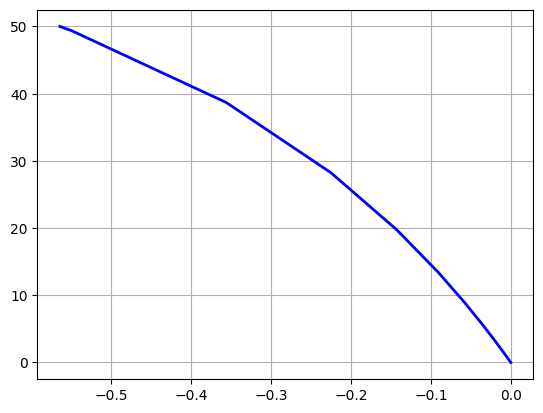

In [112]:
mapdl_1.post1()

out = mapdl_1.set("list")
print(out)

# monitor DOF
m = int(mapdl_1.get_value(entity="ACTIVE", entnum=0, item1="set", it1num="sbst"))
u_monitor_1 = np.zeros((m+1,2))
for i in range(1,m+1):
    mapdl.set(1, i)
    u_monitor_1[i,1] = mapdl_1.get_value(entity="NODE", entnum=n_El/2+1, item1="u", it1num="y")
    u_monitor_1[i,0] = mapdl_1.get_value(entity="ACTIVE", entnum=0, item1="set", it1num="time")

plt.plot(u_monitor_1[:,1], u_monitor_1[:,0], color='blue', linewidth=2)
plt.grid()
plt.show()



In [113]:
mapdl_1.exit()
mapdl.exit()